<h2 align="center"> Data Mining and Machine Learning </h2>
<h3 align="center"> Final Project </h3>
<h2 align="center"> <b> <i> CrashSpot </i> </b> </h2>
<h4 align="center"> Lorenzo Ceccanti matr. 564490 </h4>

## Comparing classification algorithms in predicting car accident severity

In this notebook, we'll compare and evaluate the performances of different classification algorithms to identify which one is the most effective in predicting the health condition of people involved in car accidents. We'll also investigate what features are the most relevant in perform such classification task according to the different classification algorithm compard in this analysis.

We'll work with the dataset in which the granularity is per occupant (a.k.a. the <i> integrated </i> dataset)

### <b> Preprocessing on the <i> integrated </i> dataset </b>

Suppose to consider the dataset `INTEGRATION_brasilEnglishFull.csv` produced during the "Data Integration" step. Such file contains the brasilian accidents from 2017 to 2023 (same data used for the first part of the project, but with details about the single person and veichle involved)

In [2]:
import os
import pandas as pd
import numpy as np
df_sampled = pd.read_csv(os.path.join('../editedDataset', 'INTEGRATION_brasilEnglishFull.csv'))

We need to perform some corrections on attributes names, due to wrong translation by the authors of the dataset.

In [3]:
# The same corrections that we've performed for the aggregated dataset
df_sampled.rename(columns={"ignored": "unharmed"}, inplace=True)
df_sampled.rename(columns={"inverse_data": "date"}, inplace=True)
df_sampled.rename(columns={"wheather_condition": "weather_condition"}, inplace=True)
pd.set_option("display.max_columns", None)
df_sampled

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,victims_condition,weather_timestamp,road_direction,weather_condition,road_type,road_delineation,people,deaths,slightly_injured,severely_injured,uninjured,unharmed,total_injured,vehicles_involved,latitude,longitude,regional_x,police_station_x,id,pesid,without_passengers,veichle_id,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex,person_is_unharmed,person_is_slightly_injured,person_is_severely_injured,person_is_dead,regional_y,police_station_y,uop
0,2017-01-01,sunday,00:00:00,GO,153.0,435,ANAPOLIS,Excessive use of the car's tire,Overturn,With injured victims,Night,Decreasing,Clear sky,Double,Straight,1,0,0,1,0,0,1,1,-16.27474,-48.96909,SPRF-GO,DEL02-GO,12.0,1499,Yes,8,Motorcycle,KASINSKI/COMET 250,2011.0,Driver,Severely Injured,24,M,0,0,1,0,SPRF-GO,DEL02-GO,UOP01-DEL02-GO
1,2017-01-01,sunday,00:00:00,SC,280.0,"77,3",CORUPA,Alcohol consumption,Run-off-road,With injured victims,Night,Decreasing,Rainy,Simple,Not Reported,1,0,1,0,0,0,1,1,-26.44675,-49.20167,SPRF-SC,DEL06-SC,13.0,1892,No,4,Car,GM/CORSA SEDAN,2004.0,Driver,Slightly Injured,57,M,0,1,0,0,SPRF-SC,DEL06-SC,UOP03-DEL06-SC
2,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,With dead victims,Night,Decreasing,Cloudy,Simple,Curve,4,1,0,1,0,2,1,1,-5.43087,-42.63590,SPRF-PI,DEL01-PI,21.0,46,No,41,Car,TOYOTA/COROLLA XEI18FLEX,2009.0,Passenger,Severely Injured,33,M,0,0,1,0,SPRF-PI,DEL01-PI,UOP02-DEL01-PI
3,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,With dead victims,Night,Decreasing,Cloudy,Simple,Curve,4,1,0,1,0,2,1,1,-5.43087,-42.63590,SPRF-PI,DEL01-PI,21.0,43,No,41,Car,TOYOTA/COROLLA XEI18FLEX,2009.0,Driver,Dead,27,M,0,0,0,1,SPRF-PI,DEL01-PI,UOP02-DEL01-PI
4,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,With dead victims,Night,Decreasing,Cloudy,Simple,Curve,4,1,0,1,0,2,1,1,-5.43087,-42.63590,SPRF-PI,DEL01-PI,21.0,546,No,0,NaN,NaN,NaN,Withness,NaN,0,NaN,0,0,0,0,SPRF-PI,DEL01-PI,UOP02-DEL01-PI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162440,2023-08-31,thursday,23:20:00,RS,287.0,251,SANTA MARIA,Lane change maneuver,Side collision (same direction),Without victims,Night,Increasing,Clear sky,Double,Not Reported,2,0,0,0,1,1,0,2,-29.68774,-53.88038,SPRF-RS,DEL09-RS,545746.0,1204605,Yes,967881,Car,I/CITROEN C4 PALLAS20GLA,NaN,Driver,NaN,0,NaN,0,0,0,0,SPRF-RS,DEL09-RS,UOP01-DEL09-RS
1162441,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,With injured victims,Night,Increasing,Clear sky,Simple,Not Reported,4,0,0,1,3,0,1,2,-25.71010,-53.76859,SPRF-PR,DEL02-PR,545748.0,1204809,No,967890,Car,FIAT/UNO MILLE FIRE FLEX,2006.0,Passenger,Unharmed,64,F,1,0,0,0,SPRF-PR,DEL02-PR,UOP02-DEL02-PR
1162442,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,With injured victims,Night,Increasing,Clear sky,Simple,Not Reported,4,0,0,1,3,0,1,2,-25.71010,-53.76859,SPRF-PR,DEL02-PR,545748.0,1204614,No,967890,Car,FIAT/UNO MILLE FIRE FLEX,2006.0,Driver,Unharmed,69,M,1,0,0,0,SPRF-PR,DEL02-PR,UOP02-DEL02-PR
1162443,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,With injured victims,Night,Increasing,Clear sky,Simple,Not Reported,4,0,0,1,3,0,1,2,-25.71010,-53.76859,SPRF-PR,DEL02-PR,545748.0,1204808,No,967890,Car,FIAT/UNO MILLE FIRE FLEX,2006.0,Passenger,Severely Injured,92,F,0,0,1,0,SPRF-PR,DEL02-PR,UOP02-DEL02-PR


In [4]:
# We need to convert all the manufacturing years as integer
df_sampled["veichle_manufacturing_year"] = (
    np.floor(df_sampled["veichle_manufacturing_year"]).astype("Int64")
)

Let's drop the un-useful columns for this analysis (some road features and the attribute dependent to the "per accident" granularity):
- victims_condition
- road_type
- deaths
- slightly_injured
- severely_injured
- uninjured
- unharmed
- total_injured
- vehicles_involved
- police_station_x
- id
- pesid
- veichle_id
- police_station_y
- uop
- without_passengers
- people

In [ ]:
# Dropping the columns above
df_sampled.drop(columns=['victims_condition', 'road_type', 
                         'deaths', 'slightly_injured', 
                         'severely_injured', 'uninjured', 'unharmed', 'total_injured',
                          'vehicles_involved', 'police_station_x', 'id', 'pesid', 'veichle_id',
                           'police_station_y', 'uop', 'without_passengers', 'people', 'latitude', 'longitude',
                           "person_is_unharmed", "person_is_slightly_injured", "person_is_severely_injured","person_is_dead"], inplace=True)

Also, we suppose not to work from the point of view of pedestrians, as there are some records that register information about the accidents from the point of view of a pedestrian. Same thing applies to knight riders.

In [6]:
pedestrian_idx = df_sampled.query("person_kind == 'Pedestrian' or person_kind == 'Knight'").index
df_sampled.drop(index=pedestrian_idx, inplace=True)

Let's do a little bit of pre-processing on the "integration" dataset. The attribute we'll use as "label" for our classification problem is `person_condition`.

In [7]:
df_sampled['person_condition'].value_counts(dropna=False)

person_condition
Unharmed            467973
Slightly Injured    367879
NaN                 165964
Severely Injured    108109
Dead                 29665
Name: count, dtype: int64

We have four possible classes:
- Unharmed
- Slightly Injured
- Severely Injured
- Dead

We notice also that there's a very large number of instances without class. Let's remove them.

In [8]:
df_sampled.dropna(subset=["person_condition"], inplace=True)

In [9]:
pd.set_option("display.max_columns", None)
df_sampled

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
0,2017-01-01,sunday,00:00:00,GO,153.0,435,ANAPOLIS,Excessive use of the car's tire,Overturn,Night,Decreasing,Clear sky,Motorcycle,KASINSKI/COMET 250,2011,Driver,Severely Injured,24,M
1,2017-01-01,sunday,00:00:00,SC,280.0,"77,3",CORUPA,Alcohol consumption,Run-off-road,Night,Decreasing,Rainy,Car,GM/CORSA SEDAN,2004,Driver,Slightly Injured,57,M
2,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,Night,Decreasing,Cloudy,Car,TOYOTA/COROLLA XEI18FLEX,2009,Passenger,Severely Injured,33,M
3,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,Night,Decreasing,Cloudy,Car,TOYOTA/COROLLA XEI18FLEX,2009,Driver,Dead,27,M
6,2017-01-01,sunday,00:00:00,PR,376.0,112,PARANAVAI,Natural phenomena,Fall of vehicle occupant,Night,Increasing,Rainy,Motorcycle,HONDA/CG 150 TITAN ESD,2005,Driver,Severely Injured,19,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162439,2023-08-31,thursday,23:20:00,RS,287.0,251,SANTA MARIA,Lane change maneuver,Side collision (same direction),Night,Increasing,Clear sky,Car,GM/MONZA SL,1988,Driver,Unharmed,64,M
1162441,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Passenger,Unharmed,64,F
1162442,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Driver,Unharmed,69,M
1162443,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Passenger,Severely Injured,92,F


From visually inspecting the dataframe with VS Code Data Wrangler extension, we've discovered that veichle of type "Other" very often don't have any information about the brand and the manufacturing year. For this reason, we remove them from the collection of instances.

In [10]:
df_sampled = df_sampled.query("veichle_type != 'Others'")

In [11]:
df_sampled

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
0,2017-01-01,sunday,00:00:00,GO,153.0,435,ANAPOLIS,Excessive use of the car's tire,Overturn,Night,Decreasing,Clear sky,Motorcycle,KASINSKI/COMET 250,2011,Driver,Severely Injured,24,M
1,2017-01-01,sunday,00:00:00,SC,280.0,"77,3",CORUPA,Alcohol consumption,Run-off-road,Night,Decreasing,Rainy,Car,GM/CORSA SEDAN,2004,Driver,Slightly Injured,57,M
2,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,Night,Decreasing,Cloudy,Car,TOYOTA/COROLLA XEI18FLEX,2009,Passenger,Severely Injured,33,M
3,2017-01-01,sunday,00:00:00,PI,316.0,"41,8",LAGOA DO PIAUI,Incompatible velocity,Run-off-road,Night,Decreasing,Cloudy,Car,TOYOTA/COROLLA XEI18FLEX,2009,Driver,Dead,27,M
6,2017-01-01,sunday,00:00:00,PR,376.0,112,PARANAVAI,Natural phenomena,Fall of vehicle occupant,Night,Increasing,Rainy,Motorcycle,HONDA/CG 150 TITAN ESD,2005,Driver,Severely Injured,19,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162439,2023-08-31,thursday,23:20:00,RS,287.0,251,SANTA MARIA,Lane change maneuver,Side collision (same direction),Night,Increasing,Clear sky,Car,GM/MONZA SL,1988,Driver,Unharmed,64,M
1162441,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Passenger,Unharmed,64,F
1162442,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Driver,Unharmed,69,M
1162443,2023-08-31,thursday,23:59:00,PR,163.0,"83,2",PLANALTO,Disrespecting the intersection,Broadside collision,Night,Increasing,Clear sky,Car,FIAT/UNO MILLE FIRE FLEX,2006,Passenger,Severely Injured,92,F


At this point, there are still some missing values for what concerns the veichle manufacturing year (6% of the total amount of record after filtering "Others" as veichle_type). Let's find if there are some record having the brand but not the year.

In [12]:
# Let's search for the records having a veichle brand but not a manufacturing year
df_sampled[df_sampled["veichle_brand"].notna() & df_sampled["veichle_manufacturing_year"].isna()]

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
575,2017-01-01,sunday,17:50:00,SC,282.0,"466,4",PONTE SERRADA,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Car,RENAULT/SANDERO GTL 16HP,<NA>,Driver,Unharmed,0,M
687,2017-01-01,sunday,18:45:00,MT,364.0,"197,6",RONDONOPOLIS,Alcohol consumption,Run-off-road,Sunset,Increasing,Clear sky,Motorcycle,HONDA/CG 150 FAN ESI,<NA>,Driver,Slightly Injured,24,M
793,2017-01-01,sunday,21:10:00,MG,135.0,597,CORINTO,Alcohol consumption,Rear-end collision,Night,Increasing,Clear sky,Bicycle,MONARK/,<NA>,Driver,Severely Injured,38,M
2953,2017-01-05,thursday,09:05:00,RJ,40.0,"106,8",DUQUE DE CAXIAS,Driver's lack of attention to conveyance,Collision with moving object,Day,Decreasing,Clear sky,Bicycle,CALOI/MONDO,<NA>,Driver,Slightly Injured,18,M
3093,2017-01-05,thursday,15:00:00,AL,316.0,250,PILAR,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Moped,I/SHINERAY XY 50 Q,<NA>,Passenger,Severely Injured,31,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160648,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Passenger,Unharmed,12,M
1160649,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Driver,Unharmed,54,M
1161011,2023-08-28,monday,05:47:00,MS,163.0,80,ITAQUIRAI,Driver failed to keep distance from the vehicl...,Rear-end collision,Day,Increasing,Clear sky,Motorcycle,HONDA/BIZ 100 ES,<NA>,Driver,Slightly Injured,49,M
1161369,2023-08-28,monday,20:30:00,SP,381.0,77,MAIRIPORA,Slippery track,Run-off-road,Night,Decreasing,Drizzle,Car,I/RENAULT LOGAN,<NA>,Driver,Unharmed,61,M


There are about 19k. For those ones we'll try to recover the year in someway.

The remaining 33 - 19k = 14k instances that doesn't have the brand neither will be dropped.

In [13]:
df_sampled = df_sampled.dropna(subset=["veichle_brand", "veichle_manufacturing_year"], how="all")

In [14]:
# Let's search for the records having a veichle brand but not a manufacturing year
df_sampled[df_sampled["veichle_brand"].notna() & df_sampled["veichle_manufacturing_year"].isna()]

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
575,2017-01-01,sunday,17:50:00,SC,282.0,"466,4",PONTE SERRADA,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Car,RENAULT/SANDERO GTL 16HP,<NA>,Driver,Unharmed,0,M
687,2017-01-01,sunday,18:45:00,MT,364.0,"197,6",RONDONOPOLIS,Alcohol consumption,Run-off-road,Sunset,Increasing,Clear sky,Motorcycle,HONDA/CG 150 FAN ESI,<NA>,Driver,Slightly Injured,24,M
793,2017-01-01,sunday,21:10:00,MG,135.0,597,CORINTO,Alcohol consumption,Rear-end collision,Night,Increasing,Clear sky,Bicycle,MONARK/,<NA>,Driver,Severely Injured,38,M
2953,2017-01-05,thursday,09:05:00,RJ,40.0,"106,8",DUQUE DE CAXIAS,Driver's lack of attention to conveyance,Collision with moving object,Day,Decreasing,Clear sky,Bicycle,CALOI/MONDO,<NA>,Driver,Slightly Injured,18,M
3093,2017-01-05,thursday,15:00:00,AL,316.0,250,PILAR,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Moped,I/SHINERAY XY 50 Q,<NA>,Passenger,Severely Injured,31,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160648,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Passenger,Unharmed,12,M
1160649,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Driver,Unharmed,54,M
1161011,2023-08-28,monday,05:47:00,MS,163.0,80,ITAQUIRAI,Driver failed to keep distance from the vehicl...,Rear-end collision,Day,Increasing,Clear sky,Motorcycle,HONDA/BIZ 100 ES,<NA>,Driver,Slightly Injured,49,M
1161369,2023-08-28,monday,20:30:00,SP,381.0,77,MAIRIPORA,Slippery track,Run-off-road,Night,Decreasing,Drizzle,Car,I/RENAULT LOGAN,<NA>,Driver,Unharmed,61,M


In [15]:
df_sampled[df_sampled["veichle_manufacturing_year"].isna()]

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
575,2017-01-01,sunday,17:50:00,SC,282.0,"466,4",PONTE SERRADA,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Car,RENAULT/SANDERO GTL 16HP,<NA>,Driver,Unharmed,0,M
687,2017-01-01,sunday,18:45:00,MT,364.0,"197,6",RONDONOPOLIS,Alcohol consumption,Run-off-road,Sunset,Increasing,Clear sky,Motorcycle,HONDA/CG 150 FAN ESI,<NA>,Driver,Slightly Injured,24,M
793,2017-01-01,sunday,21:10:00,MG,135.0,597,CORINTO,Alcohol consumption,Rear-end collision,Night,Increasing,Clear sky,Bicycle,MONARK/,<NA>,Driver,Severely Injured,38,M
2953,2017-01-05,thursday,09:05:00,RJ,40.0,"106,8",DUQUE DE CAXIAS,Driver's lack of attention to conveyance,Collision with moving object,Day,Decreasing,Clear sky,Bicycle,CALOI/MONDO,<NA>,Driver,Slightly Injured,18,M
3093,2017-01-05,thursday,15:00:00,AL,316.0,250,PILAR,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Moped,I/SHINERAY XY 50 Q,<NA>,Passenger,Severely Injured,31,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160648,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Passenger,Unharmed,12,M
1160649,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Driver,Unharmed,54,M
1161011,2023-08-28,monday,05:47:00,MS,163.0,80,ITAQUIRAI,Driver failed to keep distance from the vehicl...,Rear-end collision,Day,Increasing,Clear sky,Motorcycle,HONDA/BIZ 100 ES,<NA>,Driver,Slightly Injured,49,M
1161369,2023-08-28,monday,20:30:00,SP,381.0,77,MAIRIPORA,Slippery track,Run-off-road,Night,Decreasing,Drizzle,Car,I/RENAULT LOGAN,<NA>,Driver,Unharmed,61,M


Question: Are there instances having the year but not the brand?

In [16]:
idx_year_not_brand = df_sampled[df_sampled["veichle_brand"].isna() & df_sampled["veichle_manufacturing_year"].notna()].index
len(idx_year_not_brand)

365

Yes, there are. 365 records. Let's drop them.

In [17]:
df_sampled = df_sampled.drop(index=idx_year_not_brand)

Another discovery: veichle_brand has a lot of hidden missing values!
- (Não Informado/Não Informado/Não Informado)

In [18]:
df_sampled[df_sampled["veichle_manufacturing_year"].isna()].query("veichle_brand == 'Não Informado/Não Informado/Não Informado'")

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
395222,2019-01-01,tuesday,01:00:00,MG,381.0,327,NOVA ERA,Driver's lack of attention to conveyance,Broadside collision,Night,Decreasing,Cloudy,Bicycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Severely Injured,34,M
395250,2019-01-01,tuesday,03:00:00,MG,50.0,65,UBERLANDIA,Driver's lack of attention to conveyance,Pedestrian collision,Night,Increasing,Windy,Car,Não Informado/Não Informado/Não Informado,<NA>,Driver,Unharmed,0,NaN
395496,2019-01-01,tuesday,16:30:00,PB,101.0,100,SANTA RITA,Driver broke the laws of transit,Side impact collision,Day,Increasing,Clear sky,Motorcycle,Não Informado/Não Informado/Não Informado,<NA>,Passenger,Severely Injured,35,F
395497,2019-01-01,tuesday,16:30:00,PB,101.0,100,SANTA RITA,Driver broke the laws of transit,Side impact collision,Day,Increasing,Clear sky,Motorcycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Severely Injured,31,M
395591,2019-01-01,tuesday,18:10:00,ES,262.0,168,IBATIBA,Driver's lack of attention to conveyance,Fall of vehicle occupant,Sunset,Increasing,Clear sky,Motorcycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Severely Injured,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884295,2021-12-31,friday,17:30:00,ES,101.0,260,SERRA,Driver's lack of reaction,Overturn,Day,Increasing,Rainy,Bicycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Slightly Injured,48,M
884326,2021-12-31,friday,18:40:00,RJ,101.0,74,CAMPOS DOS GOYTACAZES,Acessing the road without seeing the presence ...,Broadside collision,Sunset,Increasing,Clear sky,Bicycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Slightly Injured,79,M
884340,2021-12-31,friday,19:20:00,MS,163.0,"475,8",CAMPO GRANDE,Alcohol and/or drug ingestion by the pedestrian,Overturn,Night,Decreasing,Cloudy,Motorcycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Slightly Injured,36,M
884385,2021-12-31,friday,22:30:00,PB,230.0,375,CONDADO,The driver passed the next car improperly,Head-on collision,Night,Increasing,Clear sky,Motorcycle,Não Informado/Não Informado/Não Informado,<NA>,Driver,Severely Injured,16,M


They are 10k records, let's drop them.

In [19]:
idx_hidden_na = df_sampled[df_sampled["veichle_manufacturing_year"].isna()].query("veichle_brand == 'Não Informado/Não Informado/Não Informado'").index
df_sampled.drop(index=idx_hidden_na, inplace=True)

In [20]:
filter = df_sampled["veichle_brand"].notna() & df_sampled["veichle_manufacturing_year"].isna()
df_sampled[filter]

,date,week_day,hour,state,road_id,km,city,cause_of_accident,type_of_accident,weather_timestamp,road_direction,weather_condition,veichle_type,veichle_brand,veichle_manufacturing_year,person_kind,person_condition,person_age,person_sex
575,2017-01-01,sunday,17:50:00,SC,282.0,"466,4",PONTE SERRADA,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Car,RENAULT/SANDERO GTL 16HP,<NA>,Driver,Unharmed,0,M
687,2017-01-01,sunday,18:45:00,MT,364.0,"197,6",RONDONOPOLIS,Alcohol consumption,Run-off-road,Sunset,Increasing,Clear sky,Motorcycle,HONDA/CG 150 FAN ESI,<NA>,Driver,Slightly Injured,24,M
793,2017-01-01,sunday,21:10:00,MG,135.0,597,CORINTO,Alcohol consumption,Rear-end collision,Night,Increasing,Clear sky,Bicycle,MONARK/,<NA>,Driver,Severely Injured,38,M
2953,2017-01-05,thursday,09:05:00,RJ,40.0,"106,8",DUQUE DE CAXIAS,Driver's lack of attention to conveyance,Collision with moving object,Day,Decreasing,Clear sky,Bicycle,CALOI/MONDO,<NA>,Driver,Slightly Injured,18,M
3093,2017-01-05,thursday,15:00:00,AL,316.0,250,PILAR,Disrespect of safe distance from the next car,Rear-end collision,Day,Increasing,Clear sky,Moped,I/SHINERAY XY 50 Q,<NA>,Passenger,Severely Injured,31,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160648,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Passenger,Unharmed,12,M
1160649,2023-08-27,sunday,14:00:00,MG,381.0,"251,9",IPATINGA,Alcohol ingestion by the driver,Broadside collision,Day,Increasing,Rainy,Pickup truck,I/TOYOTA HILUX CDCQTA4PD,<NA>,Driver,Unharmed,54,M
1161011,2023-08-28,monday,05:47:00,MS,163.0,80,ITAQUIRAI,Driver failed to keep distance from the vehicl...,Rear-end collision,Day,Increasing,Clear sky,Motorcycle,HONDA/BIZ 100 ES,<NA>,Driver,Slightly Injured,49,M
1161369,2023-08-28,monday,20:30:00,SP,381.0,77,MAIRIPORA,Slippery track,Run-off-road,Night,Decreasing,Drizzle,Car,I/RENAULT LOGAN,<NA>,Driver,Unharmed,61,M


About 8k-9k are remaining, as expected. On them we try to reconstruct the year.

#### Injecting the dataset containing instances for Severely Injured and Dead

At this point we can notice that the dataset is very-highly class unbalanced. For such high unbalancing we can't only resort to SMOTE oversampling, otherwise we'll introduce a lot of synthetic instances and this is not something beneficial for the classification algorithm we'll use later. Fortunately, we can resort on other <i> brasilian accidents </i> data (person/veichle granularity level) that we did not consider until now so far. 

The data source is the same: <a href="https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf"> Polícia Rodoviária Federal Open Data </a>


In particular, in the notebook `dataBalancing` we performed all the crawling steps for collect those raw data, translation from Brasilian into English and we decided to filter out:
- accidents from 2007 to 2016 in which the class is `Dead` or `Severely Injured`
- 2024 and 2025 (until september 2025, not included) accidents in which the class is `Dead` or `Severely Injured`
- accidents of 2025 in which the class is `Slightly Injured`

The overall file produced to intregate our dataset and balance it is called `INTEGRATION_2007_2025_brasilEnglishFull.csv`

In [21]:
df_sampled['person_condition'].value_counts(dropna=False)

person_condition
Unharmed            460787
Slightly Injured    356561
Severely Injured    102085
Dead                 28130
Name: count, dtype: int64

In [22]:
df_worse = pd.read_csv(os.path.join('../editedDataset', 'INTEGRATION_2007_2025_brasilEnglishFull.csv'), dtype={5:"str"})
df_sampled = pd.concat([df_sampled, df_worse], ignore_index=True)

In [23]:
# To solve IntCastingNanError
df_sampled = df_sampled.dropna(subset=['road_id'])
df_sampled['person_condition'].value_counts(dropna=False)

person_condition
Unharmed            460787
Slightly Injured    395606
Severely Injured    310712
Dead                 87033
Name: count, dtype: int64

### Switching the problem into a 3 class classification problem

To achieve a situation in which the instances are more balanced in terms of class, we'll consider the accidents in which the occupant died and the accident in which the occupant is severly injured as an unique class. The class labels are redefined as follows:
- Unharmed
- Injured
- Severe

In [24]:
# To switch the problem into a 3 class classification problem
df_sampled.loc[df_sampled["person_condition"] == "Severely Injured", "person_condition"] = "Severe"
df_sampled.loc[df_sampled["person_condition"] == "Dead", "person_condition"] = "Severe"
df_sampled.loc[df_sampled["person_condition"] == "Slightly Injured", "person_condition"] = "Injured"

In [25]:
df_sampled = df_sampled.dropna(subset=['weather_timestamp', 'road_direction', 'veichle_type'])

In [26]:
df_sampled['person_condition'].value_counts(dropna=False)

person_condition
Unharmed    460787
Severe      397681
Injured     395576
Name: count, dtype: int64

### Producing a more compact attribute for the veichle brand

We can observe that veichle_brand attribute has some strange behavior in the sense that the specificity is too high.
Examples:
- FIAT/UNO MILLE WAY ECON -> FIAT UNO
- FIAT/UNO MILLE FIRE FLEX/UNO MILLE FIRE FLEX -> FIAT UNO
- FIAT/PALIO FIRE -> FIAT PALIO
- FIAT/PALIO WEEKEND -> FIAT PAILIO

We want something like: FIAT PALIO or FIAT UNO in order to try to reduce the distinct values.

For this reason, the following cell will create a new general attribute called `general_veichle_brand` in which the granularity level for the car brand is reduced.

In [27]:
def extract_general_brand(x):
    if pd.isna(x):
        return None
    # Normalization
    tokens = str(x).strip().upper().split()

    if not tokens:
        return None
    
    first = tokens[0]

    # Some brands starts with this particular pattern
    # Starting with "I/"
    if first.startswith("I/"):
        # We take what is after the "I/" and also the second token
        # this removes only I/ from the first token, but the rest of the content for
        # the first token is preserved
        
        first_clean = first.replace("I/", "") 
        second = tokens[1] if len(tokens) > 1 else "" # it's the second token, if exists

        # this is needed because sometimes we have BRAND/NAME
        combined = (first_clean + " " + second).replace("/", " ").strip()
    else:
        combined = first.replace("/", " ").strip()

    # We remove duplicates using a dictionary, because sometimes the brand or the model are repeated many times
    combined = " ".join(dict.fromkeys(combined.split()))
    return combined

df_sampled["general_veichle_brand"] = df_sampled["veichle_brand"].apply(extract_general_brand)
df_sampled = df_sampled.drop(columns=['veichle_brand'])

### Utility function generating a year according to a distribution of years.

The following function is an utility function that we'll be used later on in the `imblearn.Pipeline` for imputing an year for those instances having a veichle brand but not a veichle manufacturing year.

In [28]:
def sample_years(min_y, q1, med, q3, max_y, n, weights=(0.2, 0.6, 0.2), seed=None):
    """ This function generates the column veichle_manufacturing_year for those
    brands that don't have it. The function has to work a group of instances of the
    same brand."""

    # Here we are taking the weights object, which is a triple
    # and we are decomposing it in order to obtain the probabilities of
    # where to fall in the distribution

    rng = np.random.default_rng(seed)
    p_low, p_mid, p_high = weights

    # If the quartilies are all the same we directly return that year
    if min_y == max_y:
        return np.full(n, int(min_y))

    # u is a ndarray, whose size is n (as the number of instances of the same brand to impute)
    # each element of the array contains a number between 0 and 1 
    u = rng.random(n)

    low  = u < p_low
    mid  = (u >= p_low) & (u < p_low + p_mid)
    high = u >= (p_low + p_mid)

    # The first parameter to be specified in where is a condition
    # If condition is True, that where returns the second parameter. Otherwise the third paramter
    # is returned

    start_year = np.where(low,  min_y, np.where(mid, q1, q3))
    end_year  = np.where(low,  q1,   np.where(mid, q3, max_y))

    years = np.floor(rng.uniform(start_year, end_year, size=n)).astype(int)
    return years


### Producing discretized timing features

The following cells contains two functions which are responsible to create two categorical variables, one for converting a continuous 24h time into 8 time slots.

The other function extract a month from a datetime object.

In [29]:
# Creating categorical hour ranges
from datetime import datetime

# This function converts a h24 time into a categorical string
def get_categorical_time(datetime_str):
    time_object = datetime.strptime(datetime_str, '%H:%M:%S').time()
    match time_object.hour:
        case h if 0 <= h < 3:
            return '0-3'
        case h if 3 <= h < 6:
            return '3-6'
        case h if 6 <= h < 8:
            return '6-8'
        case h if 8 <= h < 12:
            return '8-12'
        case h if 12 <= h < 14:
            return '12-14'
        case h if 14 <= h < 18:
            return '14-18'
        case h if 18 <= h < 20:
            return '18-20'
        case h if 20 <= h < 24:
            return '20-24'

# This function extract the month from a datetime object, returning it as categorical string
def get_categorical_month(datetime_str):
    formats = [  # Three different data formats
        '%Y-%m-%d',
        "%d/%m/%Y",
        "%d/%m/%y"
    ]
    for fmt in formats:
        try:
            date_object = datetime.strptime(datetime_str, fmt)
            return date_object.month
        except ValueError:
            continue

    raise ValueError(f"Date format not expected : {datetime_str}")

Adding the attributes `timeSlot` and `month`: the date and time reference we'll maintain in our dataset.

In [30]:
df_sampled['timeSlot'] = df_sampled['hour'].apply(get_categorical_time)
df_sampled['month'] = df_sampled['date'].apply(get_categorical_month)

### Producing a more compact attribute for the cause of accident

Also for the cause of accidents, some of them are too much specific. In order to reduce the cardinality of this feature we perform a similar process to what done for the veichle brand. In the following cell we map specific cause of accidents into more general causes. The result will consist in producing a new attribute `general_cause_of_accident` that will be the cause of the accident attribute that will be considered from now on.

In [31]:
cause_mapping = {
        "Brake slam": ["Abrupt use of the car's brake"],
        "Minor traffic offense": ["Absence of sinalization",
                                "Disobedience to laws of transit by the pedestrian",
                                "car's on sidewalk", "unregulated headlights",
                                "Failed to activate the motorcycle headlight (or similar)", "Minor traffic offense"],
        "Traffic offense": ["Driver broke the laws of transit", "Irregular access",
                            "Lane change maneuver",
                            "Stopping at a prohibited place",
                            "The driver passed the next car improperly",
                            "Traffic with a motorcycle (or similar) between lanes",
                            "Temporary return",
                            "Acessing the road without seeing the presence of other vehicles"],
        "Major traffic offense": ["Disrespecting the intersection", 
                                "Driver changed the lane illegally",
                                "Driver disrespected the red traffic light",
                                "Driver was in the opposite direction",
                                "driving on the breakdown lane",
                                "Driving on the breakdown lane",
                                "Prohibited conversion", "Major traffic offense"],
        "Driver distraction": ["Driver using cellphone",
                            "Driver was sleeping",
                            "Driver's lack of reaction",
                            "Driver's lack of attention to conveyance"],
        "Road defect":  ["Inadequate sinalization of the road",
                        "Curvy road", "No breakdown lanes", "Other flaws/problems in the road",
                        "Poor ilumination (of the road)",
                        "Road's defect",
                        "Roads with holes without cement",
                        "Sinking or ondulation in the pavement",
                        "Slippery track",
                        "Uneven breakdown lane",
                        "Unlevel track",
                        "speed reducer wasn't working correctly",
                        "Prominent downhill",
                        "hidden/covered sinalization (of the road)",
                        "Traffic lights with problems",
                        "inefficiency of the drenage system",
                        "Urban area without appropriate pedestrian walking", "Road defect"],
        "Road condition": ["Accumulation of water on the road", "Fog",
                        "Natural phenomena",
                        "Obstacle in the road",
                        "Oil accumulation on the road",
                        "Rain",
                        "Smoke", "Road condition",
                        "Visibility restrictions in vertical curves",
                        "Visibility restrictions in horizontal curves",
                        "Road had lots of sand/wreckage",
                        "Road works (in maintenance)",
                        "Static object on the drainage gate",
                        "Visibility restriction",
                        "Bad positioning of traffic sign posts"],
        "Alcohol": ["Alcohol and/or drug ingestion by the pedestrian", "Alcohol consumption",
                    "Alcohol ingestion by the driver"],
        "Drugs": ["Driver was using drugs", "Drug ingestion"],
        "Driver behavior": ["External fight", "engaging in drifting"],
        "Animals": ["Animals on the road"],
        "Veichle not human fault": ["Car's brake problem", 
                        "Car's suspension system with problems", 
                        "Deficiency of vehicle's sinalization/ilumination system",
                        "Electrical or mechanical flaws",
                        "Mechanical loss/defect of vehicle"],
        "Veichle human fault": ["Excessive load/cargo", "Veichle human fault",
                                "Excessive use of the car's tire", "prohibited modification (of the car)"],
        "Driver health": ["Cardiac attack", "Driver had a cardiac attack", "mental disorder (except suicide)", "suicide (presumed)"],
        "Safe distance": ["Disrespect of safe distance from the next car",
                        "Driver failed to keep distance from the vehicle in front"],
        "High speed": ["Incompatible velocity", "High speed"],
        "Pedestrian involved": ["Pedestrian was crossing the road outside of the crosswalk",
                                "Pedestrian was walking in the road",
                                "Pedestrian's lack of attention",
                                "Unexpected pedestrian entry",
                                "Pedestrian crosswalk with insufficient width", "Pedestrian involved"],
        "Other": ["robbery attempt", "Other", "Demais falhas na via", ]
    }

In [32]:
# Since for Pandas it's more convenient to have the specific causes as key, we reverse the mapping of the dictionary
reverse_mapping = {specific: general 
                   for general, specifics in cause_mapping.items() 
                   for specific in specifics}
df_sampled["general_cause_of_accident"] = df_sampled["cause_of_accident"].map(reverse_mapping)

In [33]:
df_sampled = df_sampled.drop(columns=['date', 'hour', 'cause_of_accident'])

### Producing the <i> milestone </i> feature

The km attribute <i> per se </i> doesn't represent anything if don't considered together with the `road_id`. The km "60" of one road is not the km "60" of a totally different road! We have to create an unique attribute as string attribute. But there's a problem: we cannot permit to have too many unique instances. For this reason, we'll exploit binning.

In [34]:
df_sampled['road_id'] = df_sampled['road_id'].astype("int64")
df_sampled["km"] = df_sampled["km"].apply(
    lambda x: int(str(x).split(",")[0].strip()) if isinstance(x, str) else x
)

# Example of what binning does here
# km: 60.5 -> 60
# km: 69 -> 60
# km: 71.3 -> 70
# Here the binning consider intervals of 10 km
df_sampled["km_bin"] = (df_sampled["km"] // 10) * 10
df_sampled['milestone'] = df_sampled['road_id'].astype("str") + "/" + df_sampled["km_bin"].astype("int").astype("str")

In [35]:
df_sampled["milestone"].value_counts(dropna=False)

milestone
101/200     11149
101/210      8597
101/80       8316
116/220      8003
101/40       7558
            ...  
580/90          1
262/3790        1
469/30          1
330/670         1
342/0           1
Name: count, Length: 4222, dtype: int64

In [36]:
df_sampled = df_sampled.drop(columns=['km', 'km_bin', 'road_id'])

In [37]:
df_sampled['person_condition'].value_counts(dropna=False)

person_condition
Unharmed    460787
Severe      397681
Injured     395576
Name: count, dtype: int64

Check: this has to print only `person_sex` and `veichle_manufacturing_year`

In [38]:
nan_counts = df_sampled.isna().sum()
print(nan_counts[nan_counts > 0])

veichle_manufacturing_year    12847
person_sex                     4021
dtype: int64


<b> It's crucial to avoid the data leakage pitfall! </b> To do so, we'll immediately split our dataframe in training and test set (which is hold-out as we have circa 1 milion of instances, so due to such high dimensionality we can resort to this techinque and avoid two-nested cross validations) and we impute missing values for the attributes `veichle_manufacturing_years` and `person_sex` separately on training and test set using the same distribution/quartiles of the training set.

We also perform `K=5` fold cross-validation on a sample of 15% of instances of the training set in order to reduce the time required to perform the validation on commodity machines.

At the end, we'll consider the whole training set with the best combination of parameters that come out from the grid search cross validation and we retrieve the classification report.

In the following cells there will follow the definition of some class extending `sklearn.base.BaseEstimator` and `sklearn.base.TransformerMixin` ready to be used in the pipeline to mitigate any risk of data leakage.

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
class ManufacturingYearImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.brand_col = "general_veichle_brand"
        self.year_col = "veichle_manufacturing_year"
        self.weights = (0.2,0.6,0.2)
        self.random_state = 42
    
    def fit(self, X, y=None):
        X = X
        # We construct the quartlies using only the rows in which year
        # and brand are not null
        mask_valid = X[self.brand_col].notna() & X[self.year_col].notna()
        if not mask_valid.any():
            # Empty median: not useful data
            self.quartiles_ = pd.DataFrame(
                columns=["Min", "Q1", "Median", "Q3", "Max"], dtype=float
            )
            self.medians_pool_ = np.array([], dtype=float)
            self._rng_ = np.random.default_rng(self.random_state)
            return self
        
        quartiles = (
            X.loc[mask_valid]
            .groupby(self.brand_col)[self.year_col]
            .quantile([0, 0.25, 0.5, 0.75, 1.0])
            .unstack()
            .rename(columns={0.00: "Min", 0.25: "Q1", 0.50: "Median", 0.75: "Q3", 1.00: "Max"})
            .sort_values("Median", ascending=False)
        )

        # We keep brands containing only all the quartiles
        quartiles = quartiles.dropna(subset=["Q1", "Median", "Q3", "Max"])
        self.quartiles_ = quartiles
        # Medians pool contains the median quartlie for each brand
        self.medians_pool_ = quartiles["Median"].to_numpy() if not quartiles.empty else np.array([], dtype=float)
        self._rng_ = np.random.default_rng(self.random_state)

        return self
    
    def _impute_brand_quartiles(self, X):
        """ Imputes year_col for the brands having the quartiles (but without a year
        if considering the single instance)"""
    
        # The instances to impute: brand is there but year NaN
        mask_need = X[self.year_col].isna() & X[self.brand_col].isin(self.quartiles_.index)

        if not mask_need.any():
            return # There no exists any brand
        
        # The unique brand names among the instances to impute
        brands_needed = X.loc[mask_need, self.brand_col].unique()
        for brand in brands_needed:
            # I retrieve the row with the quartlies of the corresponding brand
            row = self.quartiles_.loc[brand]
            idx = X.index[(X[self.brand_col] == brand) & (X[self.year_col].isna())]
            if len(idx) == 0:
                continue

            years = sample_years(
                row["Min"], row["Q1"], row["Median"], row["Q3"], row["Max"],
                n=len(idx),
                weights=self.weights
            )
            X.loc[idx, self.year_col] = years
    
    def _fallback_impute(self, X):
        """ We restort to this method if there's any residual NaN
         in 'veichle_manufacturing_year.'"""
        mask_residual = X[self.year_col].isna()
        n = mask_residual.sum()
        if not mask_residual.any():
            return
        if self.medians_pool_.size > 0:
            sampled = self._rng_.choice(self.medians_pool_, size=n)
            X.loc[mask_residual, self.year_col] = np.floor(sampled)
    
    def transform(self, X, y=None):
        X_out = X.copy()

        # We inpute basing on the quarties seen at fit time (so basing on the
        # brands for which we have a distribution of veichle_manufacturing_year)

        if hasattr(self, "quartiles_") and not self.quartiles_.empty:
            self._impute_brand_quartiles(X_out)
        
        # For the residual NaN years, we resort to the median pool
        self._fallback_impute(X_out) 

        X_out[self.year_col] = X_out[self.year_col].astype("int64")

        return X_out

In [40]:
class PersonSexImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.col = "person_sex"
        self.random_state = 42
    
    def fit(self, X, y=None):
        # We take only the series 'person_sex'
        s = X[self.col]
        # In particular we create a mask for computing the probability
        # distribution obviously only for the instances having person_sex
        # different from NaN
        notna_mask = s.notna()
        self.classes_ = s[notna_mask].unique()
        self.probs = s[notna_mask].value_counts(normalize=True) 
        self._rng_ = np.random.default_rng(self.random_state)
        return self
    
    def transform(self, X, y = None):
        X_out = X.copy()
        mask_na = X_out[self.col].isna()
        if mask_na.any():
            X_out.loc[mask_na, self.col] = self._rng_.choice(
                self.classes_,
                size=mask_na.sum(),
                p=self.probs
            )
        return X_out

In [41]:
class FrequencySubsetEncoder(BaseEstimator, TransformerMixin):
    """ Transforms categorical columns into a frequency columns"""
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        X = X.copy()
        self.maps_ = {}
        for col in self.cols:
            vc = X[col].value_counts(normalize=True)
            self.maps_[col] = vc
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].map(self.maps_[col]).fillna(0.0)
        return X

In [42]:
from sklearn.preprocessing import OrdinalEncoder
class OrdinalSubsetEncoder(BaseEstimator, TransformerMixin):
    """" Performs ordinal encoding for multiple columns"""
    def __init__(self, cols):
        self.cols = cols
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", # just as a precaution
            unknown_value=-1
        )

    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.cols] = self.encoder.transform(X[self.cols])
        return X

In [43]:
from sklearn.feature_extraction import FeatureHasher
import pandas as pd

class HashSetEncoder(BaseEstimator, TransformerMixin):
    """ Performs the 'hash trick' on multiple columns"""
    def __init__(self, cols, n_features=8, alternate_sign=False):
        self.cols = cols
        self.n_features = n_features
        self.alternate_sign = alternate_sign
    def fit(self, X, y=None):
        self.hasher = FeatureHasher(
            n_features=self.n_features,
            input_type="dict",
            alternate_sign=self.alternate_sign
        )
        return self

    def transform(self, X):
        X = X.copy()
        # Important. FeatureHasher performs the hash trick but expects to
        # receive the instances a list of dictionaries
        # where the key is the feature name and the value are the instances
        dicts = X[self.cols].astype(str).to_dict(orient="records")
        hashed = self.hasher.transform(dicts).toarray() # we convert a CSR matrix (a compressed matrix which is sparse) into dense data, as required by SMOTE later
        hashed_df = pd.DataFrame(
            hashed,
            columns=[f"hash_{i}" for i in range(self.n_features)],
            index=X.index
        )
        X = X.drop(columns=self.cols)
        X = pd.concat([X, hashed_df], axis=1)
        return X

### Preparing the dataset <i> in its final form </i> for the classification task

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from time import time


df = df_sampled.copy()
X = df.copy()
y = X.pop('person_condition') # the column consisting in the class to predict

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1254044 entries, 0 to 1254150
Data columns (total 17 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   week_day                    1254044 non-null  object 
 1   state                       1254044 non-null  object 
 2   city                        1254044 non-null  object 
 3   type_of_accident            1254044 non-null  object 
 4   weather_timestamp           1254044 non-null  object 
 5   road_direction              1254044 non-null  object 
 6   weather_condition           1254044 non-null  object 
 7   veichle_type                1254044 non-null  object 
 8   veichle_manufacturing_year  1241197 non-null  Float64
 9   person_kind                 1254044 non-null  object 
 10  person_age                  1254044 non-null  float64
 11  person_sex                  1250023 non-null  object 
 12  general_veichle_brand       1254044 non-null  object 
 13  ti

In [45]:
ordinal_cols = [
    "week_day", "person_kind", "person_sex", "weather_timestamp", "road_direction", "weather_condition", "timeSlot"
]

frequency_cols = [
    "state", "type_of_accident", "veichle_type", "general_cause_of_accident", 
    "city", "general_veichle_brand", "milestone"
]

# -- HOLDING OUT A TEST SET FROM THE WHOLE DATA TO PERFORM FINAL EVALUATION ON IT
# The stratify parameter is used to maintain the same proportion of the classes
# both in the training and in the test set.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Sampling for Grid Search
sample_frac = 0.15
X_gs, _, y_gs, _ = train_test_split(
    X_train_full, y_train_full, train_size=sample_frac, stratify=y_train_full, random_state=42
)

Utility functions to directly read the results without losing time in refitting the models.

In [46]:
import json

# CROSS-VALIDATION
def save_cv_results(dict, cv_df, path):
    # Saving the output of the fit function
    with open(f"./{path}/cv_output.json", "w") as f:
        json.dump(dict, f, indent=4)
    # Saving the dataframe
    cv_df.to_csv(f"./{path}/results_cv.csv")
    
def load_cv_results(path):
    # Loading the output of the fit functiojn
    with open(f"./{path}/cv_output.json", "r") as f:
        dict = json.load(f)
    # Loading the dataframe
    cv_df = pd.read_csv(os.path.join(f'./{path}', 'results_cv.csv'))
    return dict["time_cv"], dict["grid_search_best_params"], dict["grid_search_best_score"], cv_df

# FEATURE IMPORTANCES
def save_feature_importances(fi_df, path):
    # Saving the dataframe
    fi_df.to_csv(f"./{path}/feat_importances.csv")

def load_feature_importances(path):
    # Loading the dataframe
    cv_df = pd.read_csv(os.path.join(f'./{path}', 'feat_importances.csv'))
    return cv_df

# CLASSIFICATION REPORT
def save_classification_report(cr, test_time, path):
    # Saving the time into a JSON file
    dict = {
        "test_time": test_time
    }
    with open(f"./{path}/test_time.json", "w") as f:
        json.dump(dict, f, indent=4)
    # Saving the classification report
    with open(f"./{path}/classification_report.txt", "w") as f:
        f.write(cr)

def load_classification_report(path):
    # Loading the JSON file
    with open(f"./{path}/test_time.json", "r") as f:
        dict = json.load(f)
    test_time = dict["test_time"]
    with open(f"./{path}/classification_report.txt", "r") as f:
        cr = f.read()
    return test_time, cr

# CONFUSION MATRIX
def save_confusion_matrix(cm, pipe_classes, path):
    # Saving the numpy array (the confusion matrix)
    np.save(f"./{path}/confusion_matrix.npy", cm)
    # Saving the pipe classes
    np.save(f"./{path}/pipe_classes.npy", pipe_classes)

def load_confusion_matrix(path):
    """ Returns the confusion matrix as a numpy array and the pipeclasses to be
    used in seaborn"""
    cm = np.load(f"./{path}/confusion_matrix.npy")
    pipe_classes = np.load(f"./{path}/pipe_classes.npy", allow_pickle=True) # to avoid having errors, we are dealing with ndarray of objects
    return cm, pipe_classes

In [47]:
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### RandomForestClassifier

In [48]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
# -------------------------------------
# Grid search on the sample
pipe = Pipeline([
    ("year_imputer", ManufacturingYearImputer()),
    ("sex_imputer", PersonSexImputer()),
    ("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)),
    ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)),
    ("resample", SMOTE(random_state=42)),
    ("select", SelectKBest(score_func=mutual_info_classif)),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=1))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pg = {
    "select__k": [10],
    "clf__n_estimators": [700, 850],
    "clf__max_features": ["log2"],
    "clf__max_depth": [20, 24]
}
# The Grid Search is performed only on training data
# With n_jobs = -1 we are saying that we want to use all cores
grid_search = GridSearchCV(pipe, param_grid=pg, scoring="f1_weighted", cv=skf, n_jobs=8, verbose=2, refit=True)
# Checking the existence of previous metrics
folder = "reports_RF"
if not os.path.exists(folder):
    # 1) If the folder doesn't exists, we'll proceed to fitting
    os.makedirs(folder)

    # 2) Cross-Validation
    start = time()
    grid_search.fit(X_gs, y_gs)
    time_cv_rf = time() - start

    # We save the results onto JSON+CSV files
    grid_search_best_params = grid_search.best_params_
    grid_search_best_score = grid_search.best_score_
    cv_json = {
        "time_cv": time_cv_rf,
        "grid_search_best_params": grid_search_best_params,
        "grid_search_best_score": grid_search_best_score
    }
    results_cv_rf = pd.DataFrame(grid_search.cv_results_)
    results_cv_rf = results_cv_rf.sort_values(by="rank_test_score", ascending=True)
    save_cv_results(cv_json, results_cv_rf, folder)

    # 3) Feature importances
    best_pipe = grid_search.best_estimator_
    mask = best_pipe.named_steps["select"].get_support()

    selected_features = X.columns[mask]

    clf = best_pipe.named_steps["clf"]
    importances = clf.feature_importances_

    feat_importances_rf = pd.DataFrame({
        "feature": selected_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Saving feature importances into file
    save_feature_importances(feat_importances_rf, folder)

    # 4) Taking the best parameter, train the model on the entire dataset and testing on the holdout
    best_params = grid_search.best_params_
    X_train_fs = X_train_full[selected_features]
    X_test_fs = X_test[selected_features]

    ordinal_cols = [col for col in ordinal_cols if col in selected_features]
    frequency_cols = [col for col in frequency_cols if col in selected_features]

    rf_params = {k.replace("clf__", ""): v for k, v in best_params.items() if k.startswith("clf__")}
    clf_final = RandomForestClassifier(**rf_params, random_state=42, n_jobs=8)

    pipe_components = [("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)), ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)), 
                    ("resample", SMOTE(random_state=42)), ("clf", clf_final)]

    if 'person_sex' in selected_features:
        pipe_components.insert(0, ("sex_imputer", PersonSexImputer()))
    if 'veichle_manufacturing_year' in selected_features:
        pipe_components.insert(0, ("year_imputer", ManufacturingYearImputer()))

    pipe = Pipeline(pipe_components)
    start = time()
    pipe.fit(X_train_fs, y_train_full)
    y_pred = pipe.predict(X_test_fs)
    time_test_rf = time() - start

    classification_report_rf = classification_report(y_test, y_pred)
    save_classification_report(classification_report_rf, time_test_rf, folder)

    # 5) Confusion matrix
    cm_rf = confusion_matrix(y_test, y_pred)
    # Saving the nparray
    pipe_classes = pipe.classes_
    save_confusion_matrix(cm_rf, pipe_classes, folder)

else:
    # If the folder already exists, we only load the results from the JSON + CSV files
    time_cv_rf, grid_search_best_params, grid_search_best_score, results_cv_rf = load_cv_results(folder)
    # Feature importances
    feat_importances_rf = load_feature_importances(folder)
    # 4) Taking the best parameter, train the model on the entire dataset and testing on the holdout
    time_test_rf, classification_report_rf = load_classification_report(folder)
    # 5) Confusion matrix
    cm_rf, pipe_classes = load_confusion_matrix(folder)

#### Grid search Cross-Validation - Results:

In [49]:
print(f"CV took: {(time_cv_rf):.2f} seconds")
print("Best params (on sample):", grid_search_best_params)
print("CV best score (on sample):", grid_search_best_score)

CV took: 1222.01 seconds
Best params (on sample): {'clf__max_depth': 24, 'clf__max_features': 'log2', 'clf__n_estimators': 850, 'select__k': 10}
CV best score (on sample): 0.6414143588951806


In [50]:
results_cv_rf

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__max_features,param_clf__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3,302.120689,28.283163,8.920515,1.510134,24,log2,850,10,"{'clf__max_depth': 24, 'clf__max_features': 'l...",0.637539,0.651681,0.640594,0.640476,0.636782,0.641414,0.005356,1
1,0,283.071095,3.909091,8.247380,0.102730,20,log2,700,10,"{'clf__max_depth': 20, 'clf__max_features': 'l...",0.635984,0.641634,0.651839,0.640636,0.636477,0.641314,0.005712,2
2,2,306.939788,3.284312,12.632912,4.376622,24,log2,700,10,"{'clf__max_depth': 24, 'clf__max_features': 'l...",0.636677,0.641841,0.641224,0.639932,0.646335,0.641202,0.003126,3
3,1,337.836624,4.200619,10.227216,0.923534,20,log2,850,10,"{'clf__max_depth': 20, 'clf__max_features': 'l...",0.636490,0.643482,0.641292,0.640123,0.636727,0.639623,0.002688,4


In [51]:
feat_importances_rf

,Unnamed: 0,feature,importance
0,9,milestone,0.120365
1,1,city,0.119423
2,5,person_age,0.119356
3,7,general_veichle_brand,0.114539
4,4,veichle_manufacturing_year,0.113133
5,8,general_cause_of_accident,0.106648
6,2,type_of_accident,0.105899
7,3,veichle_type,0.101116
8,0,state,0.079567
9,6,person_sex,0.019954


In [52]:
print(f"Process took: {(time_test_rf):.2f} seconds")
print(classification_report_rf)

Process took: 778.01 seconds
              precision    recall  f1-score   support

     Injured       0.59      0.58      0.59     79115
      Severe       0.73      0.65      0.69     79536
    Unharmed       0.71      0.79      0.75     92158

    accuracy                           0.68    250809
   macro avg       0.68      0.68      0.68    250809
weighted avg       0.68      0.68      0.68    250809



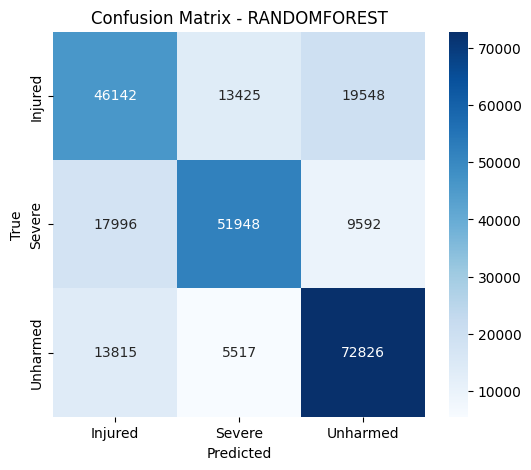

In [53]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipe_classes,
            yticklabels=pipe_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RANDOMFOREST")
plt.show()

### Saving the model

In [ ]:
import joblib
# 3.8 Gigabyte
def save_joblib_model():
   
    if not os.path.exists("../models"):
        os.makedirs("../models")
    if not os.path.exists("../models/randomForest.joblib"):
        joblib.dump(pipe, "../models/randomForest.joblib", compress=6)

#### AdaBoost

In [55]:
# ADABOOST CLASSIFIER
# -------------------------------------
# Grid search on the sample
pipe = Pipeline([
    ("year_imputer", ManufacturingYearImputer()),
    ("sex_imputer", PersonSexImputer()),
    ("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)),
    ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)),
    ("resample", SMOTE(random_state=42)),
    ("select", SelectKBest(score_func=mutual_info_classif)),
    ("clf", AdaBoostClassifier(random_state=42))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pg = {
    "select__k": [10],
    "clf__n_estimators": [500, 600, 700, 800],
    "clf__learning_rate": [0.6, 0.65]
}
# The Grid Search is performed only on training data
# With n_jobs = -1 we are saying that we want to use all cores
grid_search = GridSearchCV(pipe, param_grid=pg, scoring="f1_weighted", cv=skf, n_jobs=8, verbose=2, refit=True)
folder = "reports_ADA"
if not os.path.exists(folder):
    os.makedirs(folder)

    start = time()
    grid_search.fit(X_gs, y_gs)
    time_cv_adaboost = time() - start

    grid_search_best_params = grid_search.best_params_
    grid_search_best_score = grid_search.best_score_
    cv_json = {
        "time_cv": time_cv_adaboost,
        "grid_search_best_params": grid_search_best_params,
        "grid_search_best_score": grid_search_best_score
    }
    results_cv_adaboost = pd.DataFrame(grid_search.cv_results_)
    results_cv_adaboost = results_cv_adaboost.sort_values(by="rank_test_score", ascending=True)
    save_cv_results(cv_json, results_cv_adaboost, folder)

    best_pipe = grid_search.best_estimator_
    mask = best_pipe.named_steps["select"].get_support()

    selected_features = X.columns[mask]

    clf = best_pipe.named_steps["clf"]
    importances = clf.feature_importances_

    feat_importances_adaboost = pd.DataFrame({
        "feature": selected_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    save_feature_importances(feat_importances_adaboost, folder)

    best_params = grid_search.best_params_
    X_train_fs = X_train_full[selected_features]
    X_test_fs = X_test[selected_features]

    ordinal_cols = [col for col in ordinal_cols if col in selected_features]
    frequency_cols = [col for col in frequency_cols if col in selected_features]

    rf_params = {k.replace("clf__", ""): v for k, v in best_params.items() if k.startswith("clf__")}
    clf_final = AdaBoostClassifier(**rf_params, random_state=42)

    pipe_components = [("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)), ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)), 
                    ("resample", SMOTE(random_state=42)), ("clf", clf_final)]

    if 'person_sex' in selected_features:
        pipe_components.insert(0, ("sex_imputer", PersonSexImputer()))
    if 'veichle_manufacturing_year' in selected_features:
        pipe_components.insert(0, ("year_imputer", ManufacturingYearImputer()))

    pipe = Pipeline(pipe_components)
    start = time()
    pipe.fit(X_train_fs, y_train_full)
    y_pred = pipe.predict(X_test_fs)
    time_test_adaboost = time() - start

    classification_report_adaboost = classification_report(y_test, y_pred)
    save_classification_report(classification_report_adaboost, time_test_adaboost, folder)

    cm_ada = confusion_matrix(y_test, y_pred)
    pipe_classes = pipe.classes_
    save_confusion_matrix(cm_ada, pipe_classes, folder)
else:
    time_cv_adaboost, grid_search_best_params, grid_search_best_score, results_cv_adaboost = load_cv_results(folder)
    feat_importances_adaboost = load_feature_importances(folder)
    time_test_adaboost, classification_report_adaboost = load_classification_report(folder)
    cm_ada, pipe_classes = load_confusion_matrix(folder)

In [56]:
print(f"CV took: {(time_cv_adaboost):.2f} seconds")
print("Best params (on sample):", grid_search_best_params)
print("CV best score (on sample):", grid_search_best_score)

CV took: 1493.30 seconds
Best params (on sample): {'clf__learning_rate': 0.6, 'clf__n_estimators': 700, 'select__k': 10}
CV best score (on sample): 0.599850227462397


In [57]:
results_cv_adaboost

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2,259.911802,0.680356,4.288477,0.132482,0.60,700,10,"{'clf__learning_rate': 0.6, 'clf__n_estimators...",0.592852,0.596452,0.605446,0.601305,0.603195,0.599850,0.004586,1
1,7,268.044164,10.571286,3.289668,0.328728,0.65,800,10,"{'clf__learning_rate': 0.65, 'clf__n_estimator...",0.594732,0.600419,0.596229,0.597738,0.606755,0.599175,0.004230,2
2,3,292.470156,1.269749,4.602009,0.127231,0.60,800,10,"{'clf__learning_rate': 0.6, 'clf__n_estimators...",0.591525,0.599894,0.601878,0.599650,0.595968,0.597783,0.003665,3
3,5,229.751906,1.844615,3.824904,0.117348,0.65,600,10,"{'clf__learning_rate': 0.65, 'clf__n_estimator...",0.591662,0.609228,0.592822,0.597740,0.595341,0.597358,0.006295,4
4,6,259.871500,1.427032,4.174446,0.206835,0.65,700,10,"{'clf__learning_rate': 0.65, 'clf__n_estimator...",0.596093,0.598176,0.592431,0.600063,0.597819,0.596916,0.002573,5
5,1,228.545018,0.764698,3.695760,0.157235,0.60,600,10,"{'clf__learning_rate': 0.6, 'clf__n_estimators...",0.587536,0.594133,0.589554,0.609740,0.591853,0.594563,0.007904,6
6,4,198.185882,0.314758,3.303360,0.074765,0.65,500,10,"{'clf__learning_rate': 0.65, 'clf__n_estimator...",0.589545,0.596356,0.592459,0.593221,0.600782,0.594473,0.003828,7
7,0,197.256547,0.857144,3.703902,0.141353,0.60,500,10,"{'clf__learning_rate': 0.6, 'clf__n_estimators...",0.582781,0.591804,0.600510,0.595330,0.590889,0.592263,0.005821,8


In [58]:
feat_importances_adaboost

,Unnamed: 0,feature,importance
0,3,veichle_type,0.289424
1,4,veichle_manufacturing_year,0.219744
2,2,type_of_accident,0.171202
3,8,general_cause_of_accident,0.162478
4,7,general_veichle_brand,0.054795
5,6,person_sex,0.030498
6,5,person_age,0.028006
7,1,city,0.017202
8,9,milestone,0.015717
9,0,state,0.010934


In [59]:
print(f"Process took: {(time_test_adaboost):.2f} seconds")
print(classification_report_adaboost)

Process took: 1791.23 seconds
              precision    recall  f1-score   support

     Injured       0.52      0.50      0.51     79115
      Severe       0.65      0.58      0.61     79536
    Unharmed       0.64      0.73      0.68     92158

    accuracy                           0.61    250809
   macro avg       0.60      0.60      0.60    250809
weighted avg       0.61      0.61      0.61    250809



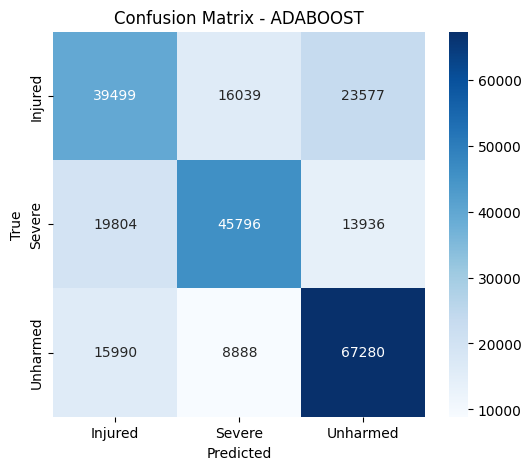

In [60]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipe_classes,
            yticklabels=pipe_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ADABOOST")
plt.show()

#### XGBoost

In [61]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# XGBoost requires label encoding also on the class attribute
le = LabelEncoder()
y_gs_enc = le.fit_transform(y_gs)
n_classes = len(le.classes_)

# -------------------------------------
# Grid search on the sample
pipe = Pipeline([
    ("year_imputer", ManufacturingYearImputer()),
    ("sex_imputer", PersonSexImputer()),
    ("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)),
    ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)),
    ("resample", SMOTE(random_state=42)),
    ("select", SelectKBest(score_func=mutual_info_classif)),
    ("clf", XGBClassifier(objective="multi:softprob", num_class = n_classes, random_state=42))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pg = {
    "select__k": [10],
    "clf__n_estimators": [400, 500, 600],
    "clf__learning_rate": [0.2, 0.25, 0.3],
}
# The Grid Search is performed only on training data
# With n_jobs = -1 we are saying that we want to use all cores
grid_search = GridSearchCV(pipe, param_grid=pg, scoring="f1_weighted", cv=skf, n_jobs=8, verbose=2, refit=True)
folder = "reports_XG"
if not os.path.exists(folder):
    # 1) If the folder doesn't exists, we'll proceed to fitting
    # We have to create the folder first
    os.makedirs(folder)

    # 2) Cross Validation
    start = time()
    grid_search.fit(X_gs, y_gs_enc)
    time_cv_xgboost = time() - start

    # We save the results onto JSON+CSV files
    grid_search_best_params = grid_search.best_params_
    grid_search_best_score = grid_search.best_score_
    cv_json = {
        "time_cv": time_cv_xgboost,
        "grid_search_best_params": grid_search_best_params,
        "grid_search_best_score": grid_search_best_score
    }
    results_cv_xg = pd.DataFrame(grid_search.cv_results_)
    results_cv_xg = results_cv_xg.sort_values(by="rank_test_score", ascending=True)
    save_cv_results(cv_json, results_cv_xg, folder)

    # 3) Feature importances
    best_pipe = grid_search.best_estimator_
    mask = best_pipe.named_steps["select"].get_support()

    selected_features = X.columns[mask]

    clf = best_pipe.named_steps["clf"]
    importances = clf.feature_importances_

    feat_importances_xgboost = pd.DataFrame({
        "feature": selected_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Saving feature importances into file
    save_feature_importances(feat_importances_xgboost, folder)

    # 4) Taking the best parameter, train the model on the entire dataset and testing on the holdout
    best_params = grid_search.best_params_

    # Transformation required by XGBoost
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train_full)
    n_classes = len(le.classes_)

    X_train_fs = X_train_full[selected_features]
    X_test_fs = X_test[selected_features]

    ordinal_cols = [col for col in ordinal_cols if col in selected_features]
    frequency_cols = [col for col in frequency_cols if col in selected_features]

    rf_params = {k.replace("clf__", ""): v for k, v in best_params.items() if k.startswith("clf__")}
    clf_final =  XGBClassifier(**rf_params, objective="multi:softprob", num_class = n_classes, random_state=42)

    pipe_components = [("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)), ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)), 
                       ("resample", SMOTE(random_state=42)), ("clf", clf_final)]

    if 'person_sex' in selected_features:
        pipe_components.insert(0, ("sex_imputer", PersonSexImputer()))
    if 'veichle_manufacturing_year' in selected_features:
        pipe_components.insert(0, ("year_imputer", ManufacturingYearImputer()))

    pipe = Pipeline(pipe_components)
    start = time()
    pipe.fit(X_train_fs, y_train_enc)
    y_pred_enc = pipe.predict(X_test_fs)
    y_pred = le.inverse_transform(y_pred_enc)
    time_test_xgboost = time() - start
    classification_report_xg = classification_report(y_test, y_pred)
    
    save_classification_report(classification_report_xg, time_test_xgboost, folder)

    # 5) Confusion matrix
    cm_xgboost = confusion_matrix(y_test, y_pred)
    # Saving the nparray
    pipe_classes = le.inverse_transform(pipe.classes_)
    save_confusion_matrix(cm_xgboost, pipe_classes, folder)
else:
    # If the folder already exists, we only load the results from the JSON + CSV files
    # 2) Crossvalidation
    time_cv_xgboost, grid_search_best_params, grid_search_best_score, results_cv_xg = load_cv_results(folder)
    # 3) Feature importances
    feat_importances_xgboost = load_feature_importances(folder)
    # 4) Taking the best parameter, train the model on the entire dataset and testing on the holdout
    time_test_xgboost, classification_report_xg = load_classification_report(folder)
    # 5) Confusion matrix
    cm_xgboost, pipe_classes = load_confusion_matrix(folder)


In [62]:
print(f"CV took: {(time_cv_xgboost):.2f} seconds")
print("Best params (on sample):", grid_search_best_params)
print("CV best score (on sample):", grid_search_best_score)

CV took: 469.93 seconds
Best params (on sample): {'clf__learning_rate': 0.25, 'clf__n_estimators': 600, 'select__k': 10}
CV best score (on sample): 0.64522215187038


In [63]:
results_cv_xg

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5,78.170347,0.743697,2.579739,0.384582,0.25,600,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.653341,0.642884,0.645183,0.642422,0.642280,0.645222,0.004192,1
1,0,66.713208,0.177042,2.219160,0.067212,0.20,400,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.641091,0.646519,0.643590,0.646342,0.646657,0.644840,0.002191,2
2,1,72.388347,0.421174,2.270816,0.556340,0.20,500,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.640435,0.647247,0.645037,0.644714,0.644651,0.644417,0.002209,3
3,2,78.980026,0.176749,2.277523,0.180821,0.20,600,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.639635,0.646593,0.644502,0.642707,0.645424,0.643772,0.002428,4
4,3,64.787195,1.581032,2.462265,0.210409,0.25,400,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.638359,0.645109,0.644309,0.644872,0.645400,0.643610,0.002650,5
5,6,64.456774,2.893236,2.129096,0.313591,0.30,400,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.639630,0.645684,0.643386,0.644712,0.641817,0.643046,0.002146,6
6,4,70.455012,0.954927,2.223344,0.503561,0.25,500,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.637957,0.643293,0.645565,0.642323,0.643746,0.642577,0.002538,7
7,7,70.930390,0.421475,1.979654,0.192722,0.30,500,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.640836,0.642358,0.642392,0.641459,0.641540,0.641717,0.000590,8
8,8,60.410742,2.998198,1.816437,0.293356,0.30,600,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.637166,0.641639,0.641448,0.638503,0.642796,0.640310,0.002116,9


In [64]:
feat_importances_xgboost

,Unnamed: 0,feature,importance
0,3,veichle_type,0.242555
1,5,person_kind,0.172923
2,8,general_cause_of_accident,0.150240
3,2,type_of_accident,0.134354
4,7,general_veichle_brand,0.074558
5,4,veichle_manufacturing_year,0.072074
6,0,state,0.043267
7,1,city,0.039252
8,9,milestone,0.036236
9,6,person_age,0.034541


In [65]:
print(f"Process took: {(time_test_xgboost):.2f} seconds")
print(classification_report_xg)

Process took: 180.78 seconds
              precision    recall  f1-score   support

     Injured       0.58      0.59      0.59     79115
      Severe       0.72      0.64      0.68     79536
    Unharmed       0.72      0.78      0.75     92158

    accuracy                           0.68    250809
   macro avg       0.68      0.67      0.67    250809
weighted avg       0.68      0.68      0.68    250809



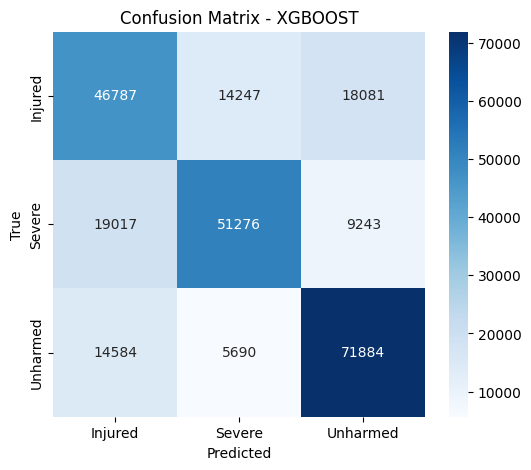

In [66]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipe_classes,
            yticklabels=pipe_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBOOST")
plt.show()

#### LightGBM

In [67]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_gs_enc = le.fit_transform(y_gs)
n_classes = len(le.classes_)


# -------------------------------------
# Grid search on the sample
pipe = Pipeline([
    ("year_imputer", ManufacturingYearImputer()),
    ("sex_imputer", PersonSexImputer()),
    ("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)),
    ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)),
    ("resample", SMOTE(random_state=42)),
    ("select", SelectKBest(score_func=mutual_info_classif)),
    ("clf", LGBMClassifier(random_state=42))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pg = {
    "select__k": [10],
    "clf__n_estimators": [400, 500, 600],
    "clf__learning_rate": [0.2, 0.25, 0.3],
}
# The Grid Search is performed only on training data
# With n_jobs = -1 we are saying that we want to use all cores
grid_search = GridSearchCV(pipe, param_grid=pg, scoring="f1_weighted", cv=skf, n_jobs=8, verbose=2, refit=True)
folder = "reports_LGB"
if not os.path.exists(folder):
    os.makedirs(folder)

    start = time()
    grid_search.fit(X_gs, y_gs_enc)
    time_cv_lightgb = time() - start

    grid_search_best_params = grid_search.best_params_
    grid_search_best_score = grid_search.best_score_
    cv_json = {
        "time_cv": time_cv_lightgb,
        "grid_search_best_params": grid_search_best_params,
        "grid_search_best_score": grid_search_best_score
    }
    results_cv_lgb = pd.DataFrame(grid_search.cv_results_)
    results_cv_lgb = results_cv_lgb.sort_values(by="rank_test_score", ascending=True)
    save_cv_results(cv_json, results_cv_lgb, folder)

    best_pipe = grid_search.best_estimator_
    mask = best_pipe.named_steps["select"].get_support()

    selected_features = X.columns[mask]

    clf = best_pipe.named_steps["clf"]
    importances = clf.feature_importances_

    feat_importances_lgb = pd.DataFrame({
        "feature": selected_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Saving feature importances into file
    save_feature_importances(feat_importances_lgb, folder)

    best_params = grid_search.best_params_

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train_full)
    n_classes = len(le.classes_)

    X_train_fs = X_train_full[selected_features]
    X_test_fs = X_test[selected_features]

    ordinal_cols = [col for col in ordinal_cols if col in selected_features]
    frequency_cols = [col for col in frequency_cols if col in selected_features]

    rf_params = {k.replace("clf__", ""): v for k, v in best_params.items() if k.startswith("clf__")}
    clf_final =  LGBMClassifier(**rf_params, random_state=42)
    pipe_components = [("ordinal_enc", OrdinalSubsetEncoder(cols=ordinal_cols)), ("freq_enc", FrequencySubsetEncoder(cols=frequency_cols)), 
                    ("resample", SMOTE(random_state=42)), ("clf", clf_final)]

    if 'person_sex' in selected_features:
        pipe_components.insert(0, ("sex_imputer", PersonSexImputer()))
    if 'veichle_manufacturing_year' in selected_features:
        pipe_components.insert(0, ("year_imputer", ManufacturingYearImputer()))

    pipe = Pipeline(pipe_components)
    start = time()
    pipe.fit(X_train_fs, y_train_enc)
    y_pred_enc = pipe.predict(X_test_fs)
    y_pred = le.inverse_transform(y_pred_enc)
    time_test_lightgb = time() - start
    classification_report_lgb = classification_report(y_test, y_pred)

    save_classification_report(classification_report_lgb, time_test_lightgb, folder)
    cm_lgb = confusion_matrix(y_test, y_pred)
    
    pipe_classes = le.inverse_transform(pipe.classes_)
    save_confusion_matrix(cm_lgb, pipe_classes, folder)
else:
    time_cv_lightgb, grid_search_best_params, grid_search_best_score, results_cv_lgb = load_cv_results(folder)
    feat_importances_lgb = load_feature_importances(folder)
    time_test_lightgb, classification_report_lgb = load_classification_report(folder)
    cm_lgb, pipe_classes = load_confusion_matrix(folder)


In [68]:
print(f"CV took: {(time_cv_lightgb):.2f} seconds")
print("Best params (on sample):", grid_search_best_params)
print("CV best score (on sample):", grid_search_best_score)

CV took: 576.53 seconds
Best params (on sample): {'clf__learning_rate': 0.25, 'clf__n_estimators': 400, 'select__k': 10}
CV best score (on sample): 0.648286928651398


In [69]:
results_cv_lgb

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3,71.315400,9.156597,1.271646,0.068367,0.25,400,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.638009,0.645772,0.657157,0.642656,0.657840,0.648287,0.007919,1
1,6,125.878117,10.814284,1.316838,0.111919,0.30,400,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.638785,0.644362,0.640991,0.638875,0.655698,0.643742,0.006311,2
2,0,62.860174,4.426523,1.325473,0.053226,0.20,400,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.637863,0.645833,0.643615,0.645278,0.645476,0.643613,0.002974,3
3,2,94.179439,12.446944,1.521195,0.096663,0.20,600,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.639608,0.644900,0.644377,0.644057,0.643435,0.643275,0.001894,4
4,1,69.381126,7.501883,1.577452,0.348561,0.20,500,10,"{'clf__learning_rate': 0.2, 'clf__n_estimators...",0.638400,0.649862,0.642342,0.640330,0.643614,0.642910,0.003903,5
5,7,131.286758,5.161259,1.434458,0.200903,0.30,500,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.635138,0.653941,0.638994,0.640303,0.640797,0.641835,0.006370,6
6,4,67.010766,13.868340,1.299928,0.085814,0.25,500,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.637447,0.644134,0.641551,0.643192,0.642128,0.641690,0.002300,7
7,5,126.896267,22.593420,1.682769,0.276784,0.25,600,10,"{'clf__learning_rate': 0.25, 'clf__n_estimator...",0.638207,0.642747,0.641594,0.640750,0.639509,0.640561,0.001583,8
8,8,71.759160,16.512490,1.153589,0.260315,0.30,600,10,"{'clf__learning_rate': 0.3, 'clf__n_estimators...",0.634093,0.637248,0.640716,0.636020,0.637307,0.637077,0.002161,9


In [70]:
feat_importances_lgb

,Unnamed: 0,feature,importance
0,9,milestone,4867
1,2,city,4668
2,6,person_age,4607
3,7,general_veichle_brand,4281
4,5,veichle_manufacturing_year,3808
5,3,type_of_accident,3497
6,1,state,2946
7,8,general_cause_of_accident,2917
8,4,veichle_type,2299
9,0,week_day,2110


In [71]:
print(f"Process took: {(time_test_lightgb):.2f} seconds")
print(classification_report_lgb)

Process took: 142.69 seconds
              precision    recall  f1-score   support

     Injured       0.58      0.54      0.56     79115
      Severe       0.71      0.64      0.68     79536
    Unharmed       0.69      0.79      0.74     92158

    accuracy                           0.66    250809
   macro avg       0.66      0.66      0.66    250809
weighted avg       0.66      0.66      0.66    250809



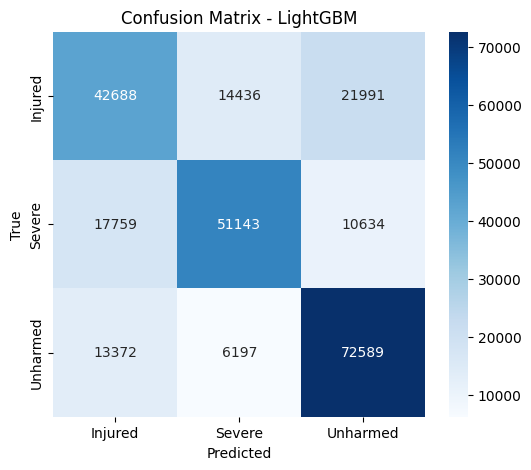

In [72]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipe_classes,
            yticklabels=pipe_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LightGBM")
plt.show()